In [1]:
# ### mount on google drive
# from google.colab import drive
# drive.mount('/content/drive/')
# import os
# os.chdir("/content/drive/My Drive/WatNet/notebooks")


In [2]:
import os
os.chdir('..')
import time
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from utils.geotif_io import readTiff, writeTiff
from utils.acc_pixel import acc_matrix
from utils.imgPatch import imgPatch
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2

In [123]:
## --- test image 
path_S2_img = 'data/test-data/T10UCV_20190827T19191_6Bands_Mountain.tif'
# path_S2_img = 'data/test-data/T13UCA_20190610T181921_6Bands_Cloudy.tif'
# path_S2_img = 'data/test-data/T49QGF_20191017T025709_6Bands_Urban.tif'
## --- test sample
path_sam = 'data/test-data/val_sam_mountain.csv'
# path_sam = 'data/test-data/val_sam_cloudy.csv'
# path_sam = 'data/test-data/val_sam_urban.csv'

## --- pre-trained model
path_model = 'model/pretrained/watnet_2.h5'
# path_model = 'model/pretrained/deepwatermapv2.h5'
## --- result path to save
path_result_map = 'result/result_.tif'
## --- super parameters
patch_size = 512
overlay = 80  # the overlay area between neighboring patches


In [124]:
# -----Load and prepare the satellite image data -----#
sen2_img, img_info = readTiff(path_in=path_S2_img)
sen2_img = np.float32(np.clip(sen2_img/10000, a_min=0, a_max=1))  ## normalization
plt.figure(figsize=(6,6))
plt.imshow(sen2_img[:, :, (2,1,0)]*5)


In [ ]:
###  ----- load the pretrained model -----#
model = watnet(input_shape=(512, 512, 6), nclasses=2)
# model = deeplabv3_plus(nclasses=2, input_shape=(512, 512, 6))
# model = deepwatermapv2(min_width=4)
model.load_weights(path_model)


Error: Kernel is dead

In [ ]:
## surface water mapping from sentinel-2 image
with tf.device('/device:GPU:0'):
    imgPatch_ins = imgPatch(sen2_img, patch_size, overlay)
    patch_list, start_list, img_patch_row, img_patch_col = imgPatch_ins.toPatch()
    result_patch_list = [model(patch[np.newaxis, :]) for patch in patch_list]
    result_patch_list = [np.squeeze(patch, axis = 0) for patch in result_patch_list]
    pro_map = imgPatch_ins.toImage(result_patch_list, img_patch_row, img_patch_col)
    cla_map = np.where(pro_map>0.5, 1, 0)


OA: 0.98
Producer acc: 0.9933
user acc: 0.9674
Confusion matrix: [[290  10]
 [  2 297]]


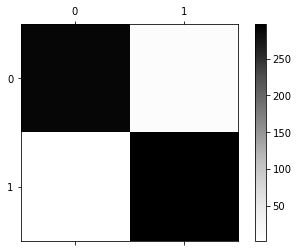

In [ ]:
## show the accuracy
df_sam = pd.read_csv(path_sam, header=0)
acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(cla_map, df_sam.to_numpy(), id_label=1)
print('OA:', acc_oa)
print('Producer acc:', acc_prod)
print('user acc:', acc_user)
print('Confusion matrix:', np.around(confus_mat,4))
plt.matshow(confus_mat,cmap=plt.cm.Greys, fignum=0)
plt.colorbar()


In [ ]:
# save the result
# writeTiff(im_data=cla_map.astype(np.int8), im_transform=img_src.transform, im_crs=img_src.crs, path_out = path_result_map)


## Accuracy comparison

In [ ]:
# path_result_map_1 = 'result/result_mountain_watnet.tif'
# path_result_map_2 = 'result/result_mountain_deepwatermapv2.tif'
# # path_result_map_3 = 'result/result_urban_watnet_3.tif'

# path_sam = 'data/test-data/val_sam_mountain.csv'
# map_src_1, cla_map_1 = readTiff(path_in=path_result_map_1)
# map_src_2, cla_map_2 = readTiff(path_in=path_result_map_2)
# # map_src_3, cla_map_3 = readTiff(path_in=path_result_map_3)
# df_sam = pd.read_csv(path_sam, header=0)


In [ ]:
# acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(cla_map_1, df_sam.to_numpy(), id_label=1)
# print('watnet OA:', acc_oa)
# acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(cla_map_2, df_sam.to_numpy(), id_label=1)
# print('watnet_2 OA:', acc_oa)
# # acc_oa, acc_prod, acc_user, confus_mat = acc_matrix(cla_map_3, df_sam.to_numpy(), id_label=1)
# # print('watnet_3 OA:', acc_oa)